# Exploratory and Statistical Data Analysis of an Online Video Game Store

## Project Overview and Goals

The online store “Strimchik” sells video games worldwide. Public sources provide historical data on game sales, user and critic ratings, genres, and platforms (e.g., Xbox, PlayStation).

**Project Goal:**  
* Identify patterns that determine a game’s success to prioritize potentially popular titles and plan marketing campaigns.  
* Assess sales dynamics across platforms and the popularity of genres.  
* Build user profiles for each region.  
* Formulate and test statistical hypotheses.

**Data Description**  
- **Name** — game title  
- **Platform** — platform  
- **Year_of_Release** — release year  
- **Genre** — game genre  
- **NA_sales** — North America sales (million copies)  
- **EU_sales** — Europe sales (million copies)  
- **JP_sales** — Japan sales (million copies)  
- **Other_sales** — other regions (million copies)  
- **Critic_Score** — critic rating (max 100)  
- **User_Score** — user rating (max 10)  
- **Rating** — ESRB age rating (Entertainment Software Rating Board)

*Note:* Data for 2016 may be incomplete.

### Data Loading

In [130]:
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [131]:
# load the dataset
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [132]:
# inspect basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [133]:
#pd.set_option('display.max_columns', None)
df.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [134]:
# check for missing values
df.isna().sum().sort_values(ascending=False)

Critic_Score       8578
Rating             6766
User_Score         6701
Year_of_Release     269
Name                  2
Genre                 2
Platform              0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
dtype: int64

#### Section Summary:
1. The dataset contains 10 columns.  
2. Three columns have 40–50% missing values.  
3. Column names are not standardized.  
4. Most numerical values are of type `float64`; data type adjustment may be required for `user_score` (also contains frequent value `tbd`).  
5. Game titles are not standardized, with some including special characters.  

### Data Preprocessing

#### Column Names

In [135]:
df.columns = df.columns.str.lower()

In [136]:
# verify that all column names were updated
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Handling Duplicates

In [137]:
# check for exact duplicates
df.duplicated().sum()

0

In [138]:
# inspect game titles to identify potential duplicates
#pd.reset_option("max_rows")
df['name'].head(1000).unique()

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii',
       'Wii Sports Resort', 'Pokemon Red/Pokemon Blue', 'Tetris',
       'New Super Mario Bros.', 'Wii Play', 'New Super Mario Bros. Wii',
       'Duck Hunt', 'Nintendogs', 'Mario Kart DS',
       'Pokemon Gold/Pokemon Silver', 'Wii Fit', 'Kinect Adventures!',
       'Wii Fit Plus', 'Grand Theft Auto V',
       'Grand Theft Auto: San Andreas', 'Super Mario World',
       'Brain Age: Train Your Brain in Minutes a Day',
       'Pokemon Diamond/Pokemon Pearl', 'Super Mario Land',
       'Super Mario Bros. 3', 'Grand Theft Auto: Vice City',
       'Pokemon Ruby/Pokemon Sapphire',
       'Brain Age 2: More Training in Minutes a Day',
       'Pokemon Black/Pokemon White', 'Gran Turismo 3: A-Spec',
       'Call of Duty: Modern Warfare 3',
       'Pokémon Yellow: Special Pikachu Edition',
       'Call of Duty: Black Ops 3', 'Call of Duty: Black Ops',
       'Pokemon X/Pokemon Y', 'Call of Duty: Black Ops II',
       'Call of Duty: Mod

In [139]:
# inspect genre names to identify potential duplicates
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

In [140]:
# convert values to a consistent case
df['genre'] = df['genre'].str.lower()

In [141]:
# inspect platform names to identify potential duplicates
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

**Conclusion:**  

1. There are many game titles, but at first glance they are all unique, so it does not make sense to remove potential duplicates in this column.  
2. Genre names are unique.  
3. Platform names are unique.  

#### Handling Missing Values

In [142]:
# check for missing values in game titles
df.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Nothing can be done here — such rows will be removed.  

In [143]:
df = df.dropna(subset=['name'])
df.reset_index(drop=True);

In [144]:
# check rows with missing values in the release year column
# sort to identify which games make sense to fill in
df.query('year_of_release.isna()').sort_values(by='user_score',ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14141,Major League Baseball 2K8,PSP,NaN,sports,0.03,0.00,0.00,0.00,63.0,tbd,E
11338,Charm Girls Club: My Fashion Show,DS,NaN,simulation,0.08,0.00,0.00,0.01,NaN,tbd,E
10993,The Daring Game for Girls,Wii,NaN,adventure,0.09,0.00,0.00,0.01,NaN,tbd,E
3081,LEGO Harry Potter: Years 5-7,DS,NaN,action,0.34,0.25,0.00,0.07,69.0,tbd,E10+
10686,Happy Feet Two,DS,NaN,action,0.08,0.01,0.00,0.01,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16180,WRC: FIA World Rally Championship,PC,NaN,racing,0.00,0.01,0.00,0.00,65.0,NaN,RP
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16329,Brothers in Arms: Furious 4,X360,NaN,shooter,0.01,0.00,0.00,0.00,NaN,NaN,M
16348,Agarest Senki: Re-appearance,PS3,NaN,role-playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN


**Conclusion:**  

1. About 10% of release years are missing.  
2. Some missing values for important games could be filled using the year mentioned in the title or based on release dates on other platforms.  
3. Many missing years are accompanied by missing sales totals and critic/user scores.  
4. For now, the missing release years will remain as they are. Deleting such a large portion of data is unnecessary.  

In [145]:
# examine missing values in the user_score column
df.query('user_score.isna()').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999.0,role-playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
18,Super Mario World,SNES,1990.0,platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,role-playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN
21,Super Mario Land,GB,1989.0,platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN
22,Super Mario Bros. 3,NES,1988.0,platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN


In [146]:
# examine missing values in the critic_score column
df.query('critic_score.isna()').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999.0,role-playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
18,Super Mario World,SNES,1990.0,platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,role-playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN
21,Super Mario Land,GB,1989.0,platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN
22,Super Mario Bros. 3,NES,1988.0,platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN


**Conclusion:**  

1. Missing critic and user scores are often correlated; in most cases, all three parameters are absent, though sometimes only one is missing.  
2. Deleting such rows would be inappropriate since they contain sales data across regions, which is useful for evaluating success. These rows will likely be excluded only from rating-based analyses.  
3. Filling the gaps with mean/median values is not meaningful, as these are subjective assessments that cannot be reasonably imputed.  

In [147]:
# examine unusual text values in the user_score column
df.query('user_score == "tbd"').head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,misc,1.65,0.57,0.00,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
718,Just Dance Kids,Wii,2010.0,misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009.0,simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004.0,action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999.0,misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001.0,puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E


**Conclusion:**  

1. The value `tbd` (likely *To Be Determined*) shows no clear pattern and may simply indicate a missing rating.  
2. It could also mean the data was intended to be filled in later but never was.  
3. Such values will be forcibly converted to missing values when casting the column to numeric type in the *Data Type Conversion* step.  

In [148]:
# examine missing values in the rating column
# add a filter for non-null user_score to exclude rows already checked above
df.query('rating.isna() and user_score.notna()').head(15)
df.query('rating.isna() and critic_score > 0').head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
822,R4: Ridge Racer Type 4,PS,1998.0,racing,0.68,0.46,0.79,0.13,88.0,9.2,NaN
1763,Football Manager 2013,PC,2012.0,sports,0.00,0.95,0.00,0.21,86.0,6.7,NaN
2054,Monster Rancher,PS,1997.0,simulation,0.12,0.08,0.74,0.07,86.0,8.3,NaN
2195,MVP Baseball 2005,XB,2005.0,sports,0.70,0.20,0.00,0.03,86.0,NaN,NaN
3054,100 Classic Books,DS,2008.0,misc,0.12,0.52,0.00,0.02,70.0,6,NaN
4214,Football Manager 2015,PC,2014.0,simulation,0.00,0.44,0.00,0.03,80.0,6,NaN
4531,Wolfenstein: The Old Blood,PS4,2015.0,action,0.10,0.25,0.02,0.06,76.0,8,NaN
4622,Metro: Last Light,PS3,2013.0,action,0.14,0.18,0.03,0.07,80.0,8.2,NaN
4887,Dark Souls III,XOne,2016.0,role-playing,0.26,0.09,0.00,0.04,87.0,8.6,NaN
5292,Metro: Last Light,X360,2013.0,action,0.17,0.15,0.00,0.03,80.0,8.4,NaN


**Conclusion:**  

1. The missing values show no clear pattern; the rating may not have been pulled in during table merging.  
2. They could be restored manually, but this is not strictly necessary.  
3. For further analysis (e.g., identifying the most popular games by genre and rating), rows with missing values will simply be excluded, which reduces the dataset by about 10% — not critical.  
4. Missing values will be filled with `"unknown"` for convenience in visualization.  

In [149]:
# replace missing values in the rating column with "unknown"
df['rating'] = df['rating'].fillna("unknown")

In [150]:
# verify that all missing values in the rating column have been replaced
df['rating'].isna().sum()

0

#### Data Type Conversion

In [151]:
# examine release years of games
df['year_of_release'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

In [152]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='ignore')
# convert release year column to numeric type
#df['year_of_release'] = df['year_of_release'].astype('Int32', errors='ignore')

In [153]:
# check if the data type was successfully converted
df['year_of_release'].dtype

dtype('float64')

In [154]:
# convert user_score column to numeric type
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [155]:
df['user_score'].dtype

dtype('float64')

#### Adding Columns

Add a column with global sales

In [156]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales','other_sales']].sum(axis=1)

In [157]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


Add a column with franchise names for popular games

In [158]:
# function to determine franchise based on game title
def franchise_games(row):
    try:
        if 'Mario' in row:
            return 'Mario'
        elif 'Pokemon' in row:
            return 'Pokemon'
        elif 'Call of Duty' in row:
            return 'Call of Duty'
        elif 'Need for Speed' in row:
            return 'Need for Speed'
        elif 'Uncharted' in row:
            return 'Uncharted'
        elif 'Grand Theft Auto' in row:
            return 'Grand Theft Auto'
        elif 'FIFA' in row:
            return 'FIFA'
        elif 'Destiny' in row:
            return 'Destiny'
        elif 'Fallout' in row:
            return 'Fallout'
        elif 'The Last of Us' in row:
            return 'The Last of Us'
        elif 'God Of War' in row:
            return 'God Of War'
        elif 'Minecraft' in row:
            return 'Minecraft'
        elif 'Battlefield' in row:
            return 'Battlefield'
        elif 'Far Cry' in row:
            return 'Far Cry'
        elif 'The Witcher' in row:
            return 'The Witcher'
        elif 'Assassin\'s Creed' in row:
            return 'Assassin\'s Creed'
        elif 'Halo' in row:
            return 'Halo'
        else:
            return 'Other'
    except:
        pass

In [159]:
# add a column for franchise
df['franchise'] = df['name'].apply(franchise_games)

Check which genres lead in categories by total sales

In [160]:
# split the dataset into 4 parts
pd.qcut(df['total_sales'], 4).value_counts()

(-0.001, 0.06]    4258
(0.17, 0.47]      4182
(0.47, 82.54]     4171
(0.06, 0.17]      4102
Name: total_sales, dtype: int64

In [161]:
# function to categorize total sales
def categorize_sales(sales):
    try:
        if 0 <= sales <= 0.05:
            return 'low'
        elif 0.05 <= sales <= 0.14:
            return 'medium'
        elif 0.14 <= sales <= 0.41:
            return 'upper'
        elif 0.41 <= sales <= 35.52:
            return 'high'
    except:
        pass

In [162]:
# add a new column with sales categories
df['sales_category'] = df['total_sales'].apply(categorize_sales)

In [163]:
# function to identify franchise by game title
def top_sales_region(na_sales,eu_sales,jp_sales):
    try:
        if eu_sales > na_sales and eu_sales > jp_sales:
            return 'EU'
        elif na_sales > eu_sales and na_sales > jp_sales:
            return 'NA'
        elif jp_sales > na_sales and jp_sales > eu_sales:
            return 'JP'
    except:
        pass

In [164]:
# add a column with the share of sales from total
df['na_sales_part'] = df['na_sales']/df['total_sales']

In [165]:
# add a column with the share of total sales
df['eu_sales_part'] = df['eu_sales']/df['total_sales']

In [166]:
# add another column with the share of total sales
df['jp_sales_part'] = df['jp_sales']/df['total_sales']

In [167]:
# add a rating scale from 1 to 5 based on age restrictions, where 1 = child and 5 = adult
def rating_range(rating):
    try:
        if rating == "EC":
            return 1
        elif rating == "E":
            return 2
        elif rating == "E 10+" or rating == "T":
            return 3
        elif rating == "M":
            return 4
        elif rating == "AO":
            return 5
        else:
            return None
    except:
        pass

In [168]:
df['rating_range'] = df['rating'].apply(rating_range)

In [169]:
df['rating_range'] = df['rating_range'].astype('Int32', errors='ignore')

In [170]:
df['rating_range'].dtype

Int32Dtype()

#### Handling Zero Values

There were no missing values in sales totals, but we can check if there are rows where all these fields equal 0.  

In [171]:
no_sales_games = df.query('total_sales == 0')
no_sales_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
16676,G1 Jockey 4 2008,PS3,2008.0,sports,0.0,0.0,0.0,0.0,NaN,NaN,unknown,0.0,Other,low,NaN,NaN,NaN,<NA>
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,racing,0.0,0.0,0.0,0.0,NaN,NaN,unknown,0.0,Other,low,NaN,NaN,NaN,<NA>


Two unclear games have no rating or sales data. These can be removed.  

In [172]:
# update the dataset
df = df.query('name not in @no_sales_games.index')
df.reset_index(drop=True)

df.query('name not in @no_sales_games.index')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
0,Wii Sports,Wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,Other,None,0.501090,0.350860,0.045675,2
1,Super Mario Bros.,NES,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24,Mario,None,0.722664,0.088966,0.169235,<NA>
2,Mario Kart Wii,Wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,Mario,high,0.441441,0.359234,0.106700,2
3,Wii Sports Resort,Wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,Other,high,0.476350,0.333537,0.100092,2
4,Pokemon Red/Pokemon Blue,GB,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38,Pokemon,high,0.359146,0.283301,0.325685,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01,Other,low,0.000000,0.000000,1.000000,<NA>
16711,LMA Manager 2007,X360,2006.0,sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01,Other,low,0.000000,1.000000,0.000000,<NA>
16712,Haitaka no Psychedelica,PSV,2016.0,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01,Other,low,0.000000,0.000000,1.000000,<NA>
16713,Spirits & Spells,GBA,2003.0,platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01,Other,low,1.000000,0.000000,0.000000,<NA>


#### Section Summary:
1. Missing values in the `rating` column replaced with `"unknown"`.  
2. Column names standardized to lowercase.  
3. Data types adjusted for `year_of_release` and `user_score`.  
4. Rows with missing game titles removed.  
5. Rows with total sales equal to 0 removed.  
6. Added a column for total sales.  
7. Added a column for sales categories.  
8. Added a column with franchise names for major games.  

### Exploratory Data Analysis

#### How many games were released each year?

Let’s examine how game popularity changed from the 1980s to 2016.  

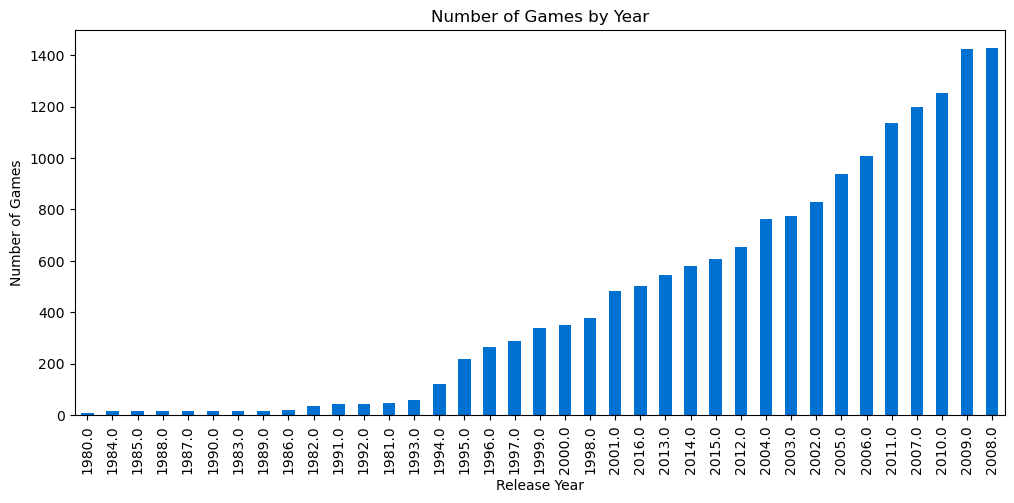

In [173]:
# plot the years with the highest number of game releases
(df['year_of_release']
.value_counts()
.sort_values(ascending=True)
.plot(grid=False, figsize=(12, 5),
      kind='bar', title='Number of Games by Year', color=['#0070D1'],
      ylabel="Number of Games",
      xlabel="Release Year")
);

**Conclusion:**  

1. The highest number of game releases occurred in 2008 and 2009.  
2. From the 1980s to the 1990s, there is a general upward trend in the number of releases.  

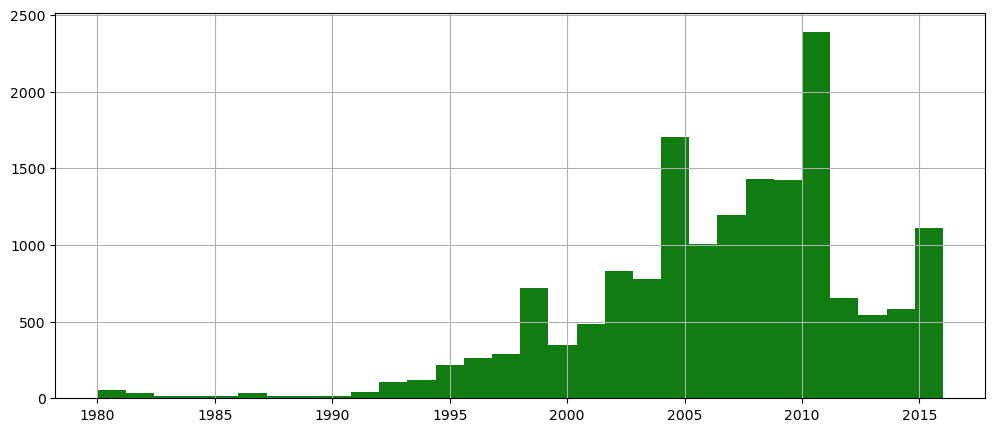

In [174]:
# plot a histogram of the distribution of game releases by year
df['year_of_release'].hist(bins=30, color=['#107C11'], figsize=(12, 5),);

**Conclusion:**  

1. Four distinct peaks in game releases are observed — 1998, 2004, 2011, and 2015/2016.  
2. Since 2004, there is no clear upward trend in the number of releases.  
3. In the early 1980s, game popularity was slightly higher than in 1983–1990.  
4. A decline in releases is visible between 2011 and 2014.  
5. For further analysis, it makes sense to use data from 1998 to 2016, with a threshold of about 500 releases per year.  

#### How did sales change across different platforms over time?

In [175]:
# select platforms with the highest total sales
(df
.pivot_table(index='platform',values='total_sales',aggfunc='sum')
.sort_values(by='total_sales',ascending=False).head(5)
)
#groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


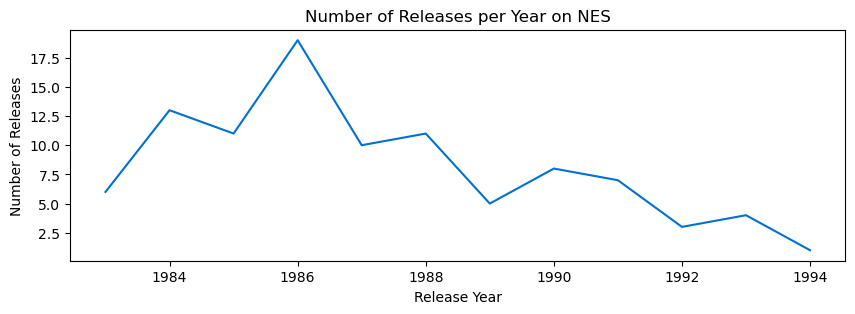

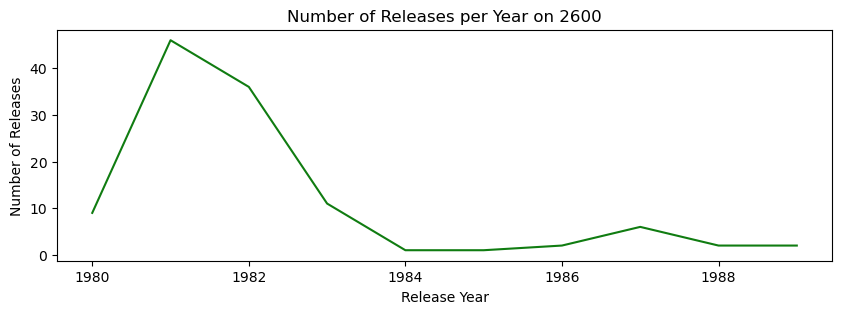

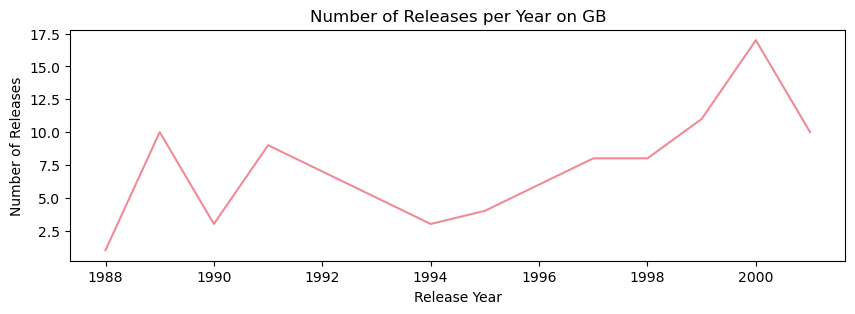

In [176]:
# plot yearly release counts for top platforms

(df.query('platform == "NES"')['year_of_release']
 .value_counts()
 .sort_index()
 .plot(grid=False, figsize=(10, 3),
       title='Number of Releases per Year on NES', color=['#0070D1'],
       ylabel="Number of Releases",
       xlabel="Release Year")
);
plt.show()

(df.query('platform == "2600"')['year_of_release']
 .value_counts()
 .sort_index()
 .plot(grid=False, figsize=(10, 3),
       title='Number of Releases per Year on 2600', color=['#107C11'],
       ylabel="Number of Releases",
       xlabel="Release Year")
);
plt.show()

(df.query('platform == "GB"')['year_of_release']
 .value_counts()
 .sort_index()
 .plot(grid=False, figsize=(10, 3),
       title='Number of Releases per Year on GB', color=['#ef8b97'],
       ylabel="Number of Releases",
       xlabel="Release Year")
);

**Conclusion:**  

1. The charts show that platforms typically lose release momentum over a span of about 10 years.  
2. Note: data for 2016 is incomplete, so this part may not fully reflect reality.  
3. For further analysis and forecasting for 2017, only the last 10 years of data will be used.  

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
 12  franchise        16713 non-null  object 
 13  sales_category   16711 non-null  object 
 14  na_sales_part    16711 non-null  float64
 15  eu_sales_part    16711 non-null  float64
 16  jp_sales_part    16711 non-null  float64
 17  rating_range

In [178]:
df.query('year_of_release.isna()').sort_values(by='user_score',ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
11119,Super Puzzle Fighter II,GBA,NaN,puzzle,0.06,0.02,0.00,0.00,83.0,9.5,E,0.08,Other,medium,0.750000,0.250000,0.0,2
10050,Star Trek: Conquest,PS2,NaN,strategy,0.06,0.04,0.00,0.01,54.0,9.1,E,0.11,Other,medium,0.545455,0.363636,0.0,2
1984,Legacy of Kain: Soul Reaver,PS,NaN,action,0.58,0.40,0.00,0.07,91.0,9.0,T,1.05,Other,high,0.552381,0.380952,0.0,3
11925,Port Royale 3,PS3,NaN,simulation,0.06,0.00,0.00,0.01,NaN,8.9,T,0.07,Other,medium,0.857143,0.000000,0.0,3
4294,The Chronicles of Riddick: Escape from Butcher...,XB,NaN,shooter,0.32,0.11,0.00,0.02,89.0,8.9,M,0.45,Other,high,0.711111,0.244444,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01,Other,low,0.000000,0.000000,1.0,<NA>
16329,Brothers in Arms: Furious 4,X360,NaN,shooter,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01,Other,low,1.000000,0.000000,0.0,4
16348,Agarest Senki: Re-appearance,PS3,NaN,role-playing,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01,Other,low,0.000000,0.000000,1.0,<NA>
16373,PDC World Championship Darts 2008,PSP,NaN,sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+,0.01,Other,low,1.000000,0.000000,0.0,<NA>


In [179]:
# create a new dataset for the last 10 years
df_ten = df.query('year_of_release > 2007')
df_new = df.query('year_of_release > 2013')

In [180]:
len(df_new)/len(df)*100

10.105905582480704

We trimmed about 90% of the dataset, keeping only the records that will help us identify profitable and relevant platforms.

#### Which platforms are leading in sales, growing, or declining? Select several potentially profitable ones.

In [181]:
# select platforms with the highest total sales over the last 10 years
(df_new
.pivot_table(index='platform',values='total_sales',aggfunc='median')
.sort_values(by='total_sales',ascending=False).head(5)
)

,total_sales
platform,
XOne,0.205
WiiU,0.190
PS4,0.185
Wii,0.180
X360,0.180


PS2 was replaced by PS4, and X360 was succeeded by XOne. Wii is gradually entering the top rankings.

We have already looked at some of these platforms; now let’s review the remaining ones.

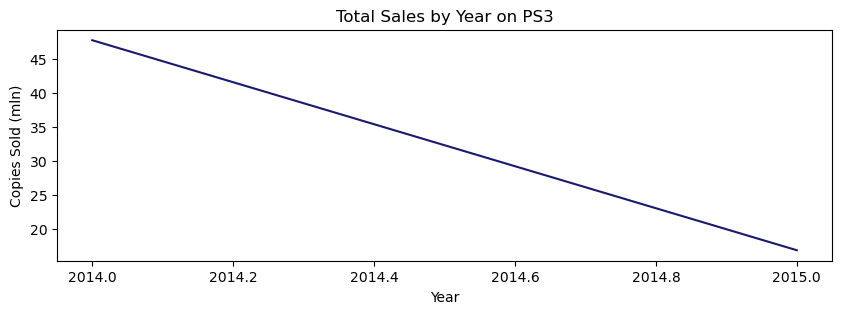

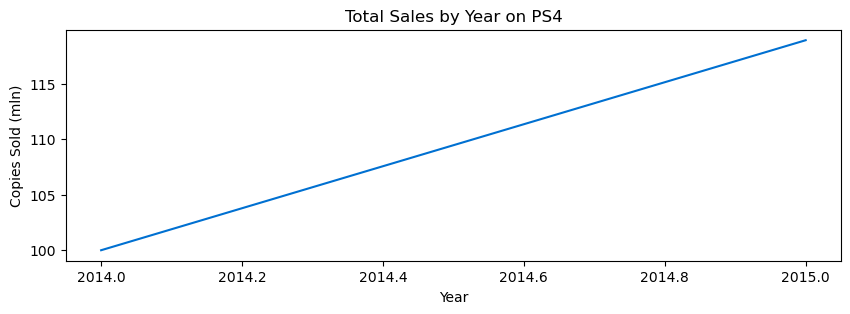

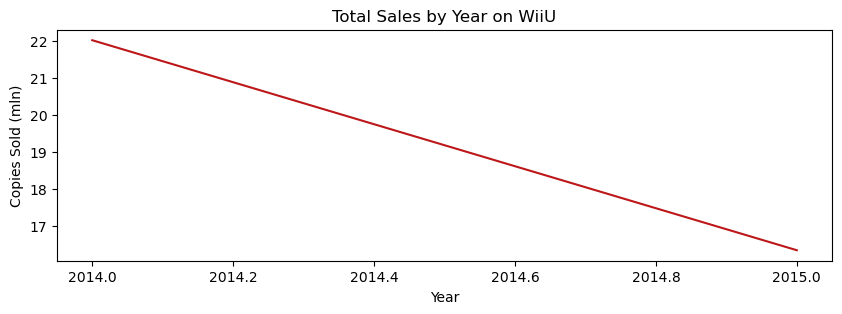

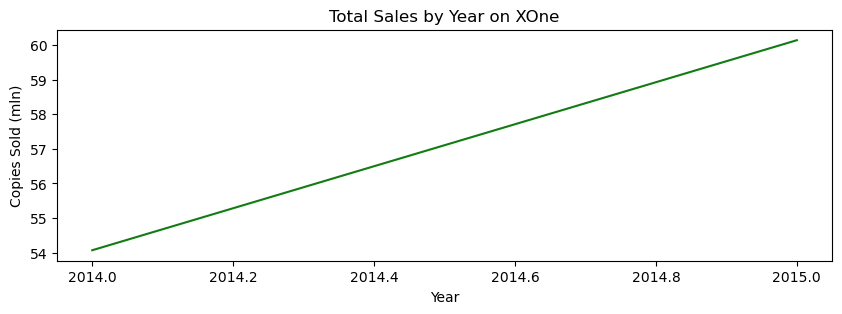

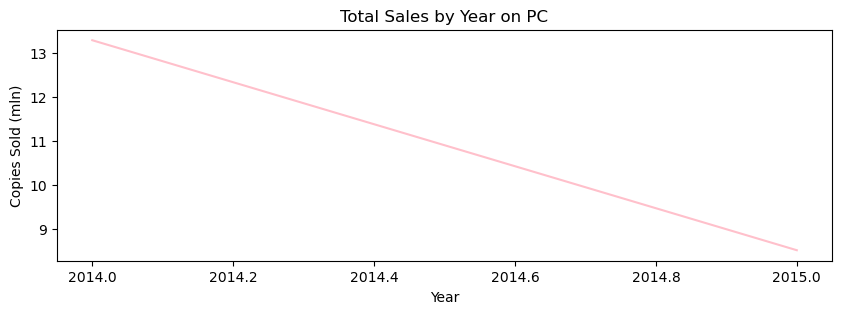

In [182]:
# plot yearly total sales for PS3
(df_new.query('platform == "PS3" and year_of_release < 2016')
.groupby('year_of_release')['total_sales'].sum()
.plot(grid=False, figsize=(10, 3),
      title='Total Sales by Year on PS3', color=['midnightblue'],
      ylabel="Copies Sold (mln)",
      xlabel="Year")
);
plt.show()

# plot yearly total sales for PS4
(df_new.query('platform == "PS4" and year_of_release < 2016')
.groupby('year_of_release')['total_sales'].sum()
.plot(grid=False, figsize=(10, 3),
      title='Total Sales by Year on PS4', color=['#0070D1'],
      ylabel="Copies Sold (mln)",
      xlabel="Year")
);
plt.show()

# plot yearly total sales for WiiU
(df_new.query('platform == "WiiU" and year_of_release < 2016')
.groupby('year_of_release')['total_sales'].sum()
.plot(grid=False, figsize=(10, 3),
      title='Total Sales by Year on WiiU', color=['#bc181a'],
      ylabel="Copies Sold (mln)",
      xlabel="Year")
);
plt.show()

# plot yearly total sales for XOne
(df_new.query('platform == "XOne" and year_of_release < 2016')
.groupby('year_of_release')['total_sales'].sum()
.plot(grid=False, figsize=(10, 3),
      title='Total Sales by Year on XOne', color=['#107C11'],
      ylabel="Copies Sold (mln)",
      xlabel="Year")
);
plt.show()

# plot yearly total sales for PC
(df_new.query('platform == "PC" and year_of_release < 2016')
.groupby('year_of_release')['total_sales'].sum()
.plot(grid=False, figsize=(10, 3),
      title='Total Sales by Year on PC', color=['pink'],
      ylabel="Copies Sold (mln)",
      xlabel="Year")
);

In [183]:
# release year of the first games on the platform
df_new.query('platform == "XOne"').sort_values(by='year_of_release').head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
5321,Sniper Elite 3,XOne,2014.0,shooter,0.2,0.11,0.0,0.03,63.0,6.6,M,0.34,Other,upper,0.588235,0.323529,0.0,4


In [184]:
# release year of the first games on the platform
df_new.query('platform == "PS4"').sort_values(by='year_of_release').head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
7973,Godzilla (2015),PS4,2014.0,action,0.11,0.03,0.02,0.03,NaN,NaN,unknown,0.19,Other,upper,0.578947,0.157895,0.105263,<NA>


**Conclusion:**  

* The charts show previously unexamined platforms and the dynamics of their sales growth or decline over the years.  
* It is evident that PS4 and XOne are experiencing sales growth.  
* Using PS2 as an example—once the leader across the full dataset—we can see that over the last 10 years it was overtaken by its next-generation successor, PS4. This suggests that, within a 10-year horizon, new console generations tend to outperform the previous ones.  

#### Distribution of Global Game Sales by Platform  

Let's examine the distribution of total sales for games released on different platforms.  

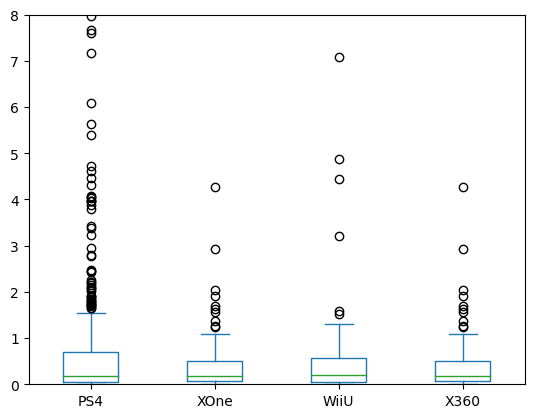

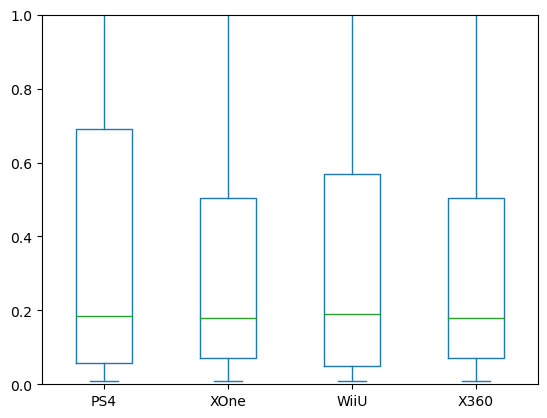

In [185]:
# examine the distribution of total sales across different platforms
ps_stat = df_new.query('platform == "PS4"')['total_sales']
xone_stat = df_new.query('platform == "XOne"')['total_sales']
wiiu_stat = df_new.query('platform == "WiiU"')['total_sales']
xone_stat = df_new.query('platform == "X360"')['total_sales']


data = pd.DataFrame({"PS4": ps_stat, "XOne": xone_stat,"WiiU": wiiu_stat, "X360": xone_stat})

data.plot(kind='box',ylim=(0,8));
plt.show()
data.plot(kind='box',ylim=(0,1));

**Conclusion:**  

1. A large number of upper-bound outliers are present across all platforms. The highest sales on PS4 reach 14 million copies.  
2. The overall spread of the data is very wide, though high sales for successful titles are plausible.  
3. The mean across platforms is nearly the same — about 200k copies. However, blockbuster games heavily skew the average, so the median will be used for further analysis.  

In [186]:
# take a look at these games
df_new.query('platform == "PS4"').sort_values(by='total_sales',ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
31,Call of Duty: Black Ops 3,PS4,2015.0,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63,Call of Duty,high,0.412167,0.400547,0.024607,<NA>
42,Grand Theft Auto V,PS4,2014.0,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,Grand Theft Auto,high,0.313788,0.500000,0.030111,4
77,FIFA 16,PS4,2015.0,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,FIFA,high,0.130536,0.713287,0.006993,2
87,Star Wars Battlefront (2015),PS4,2015.0,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98,Other,high,0.374687,0.437343,0.027569,<NA>
92,Call of Duty: Advanced Warfare,PS4,2014.0,shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66,Call of Duty,high,0.366841,0.454308,0.018277,4
94,FIFA 17,PS4,2016.0,sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60,FIFA,high,0.086842,0.756579,0.010526,2
105,Fallout 4,PS4,2015.0,role-playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17,Fallout,high,0.352859,0.456067,0.033473,4
143,FIFA 15,PS4,2014.0,sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08,FIFA,high,0.131579,0.712171,0.008224,2
154,Destiny,PS4,2014.0,shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64,Destiny,high,0.441489,0.367021,0.028369,3
171,Uncharted 4: A Thief's End,PS4,2016.0,shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39,Uncharted,high,0.343228,0.463822,0.035250,3


**Conclusion:**  

1. All the games are very well-known, and their sales volumes look plausible. The gap between the top two bestsellers and the rest of the PS4 top-10 is about twofold.  
2. Preliminary analysis shows that shooters make up the majority of the PS4 top-10.  
3. A game must perform strongly in at least two regions to achieve high total sales. No game reached the PS4 top-10 solely due to local success in a single region.  

Let's look at the sales distribution of popular game franchises across platforms:  

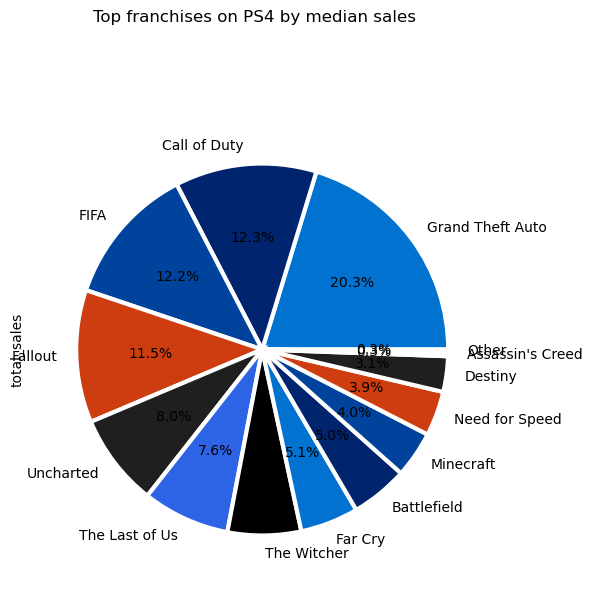

In [187]:
old_ps_logo_colors = ['#DF0024','#F3C300','#00AC9F','#2E6DB4']

ps_colors = ['#0172D0','#00246E','#00439C','#CD3D0F','#1F1F1F','#2D64E6','#000000']

# select PS4 platform, group by franchise and calculate median total sales
(df_new
 .query('platform == "PS4"')
 .pivot_table(index='franchise', values='total_sales', aggfunc='median')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='pie',
       figsize=(6, 7), 
       legend=False, 
       autopct='%1.1f%%',
       title='Top franchises on PS4 by median sales', 
       subplots=True, 
       wedgeprops={'linewidth': 3, 'edgecolor': 'white'}, 
       colors=ps_colors)
);

**Conclusion:**  

1. The clear market leaders are **Call of Duty, FIFA, Fallout, and Grand Theft Auto**.  
2. Exclusives such as **Uncharted** and **The Last of Us** account for only a small share of PS4 popularity.  

In [188]:
# look at the top-10 best-selling games on Xbox One
df_new.query('platform == "XOne"').sort_values(by='total_sales',ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range
99,Call of Duty: Black Ops 3,XOne,2015.0,shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.39,Call of Duty,high,0.621110,0.285521,0.001353,<NA>
165,Grand Theft Auto V,XOne,2014.0,action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47,Grand Theft Auto,high,0.513711,0.400366,0.000000,4
179,Call of Duty: Advanced Warfare,XOne,2014.0,shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26,Call of Duty,high,0.612167,0.294677,0.001901,4
242,Halo 5: Guardians,XOne,2015.0,shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49,Halo,high,0.619154,0.282851,0.006682,3
270,Fallout 4,XOne,2015.0,role-playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22,Fallout,high,0.594787,0.312796,0.002370,4
342,Star Wars Battlefront (2015),XOne,2015.0,shooter,2.04,1.28,0.02,0.32,NaN,NaN,unknown,3.66,Other,high,0.557377,0.349727,0.005464,<NA>
373,Assassin's Creed: Unity,XOne,2014.0,action,2.27,0.90,0.00,0.33,72.0,4.1,M,3.50,Assassin's Creed,high,0.648571,0.257143,0.000000,4
398,Destiny,XOne,2014.0,shooter,2.14,0.92,0.00,0.31,75.0,5.5,T,3.37,Destiny,high,0.635015,0.272997,0.000000,3
413,Gears of War: Ultimate Edition,XOne,2015.0,shooter,2.61,0.33,0.00,0.34,82.0,7.5,M,3.28,Other,high,0.795732,0.100610,0.000000,4
417,FIFA 16,XOne,2015.0,sports,0.89,2.12,0.00,0.24,84.0,4.4,E,3.25,FIFA,high,0.273846,0.652308,0.000000,2


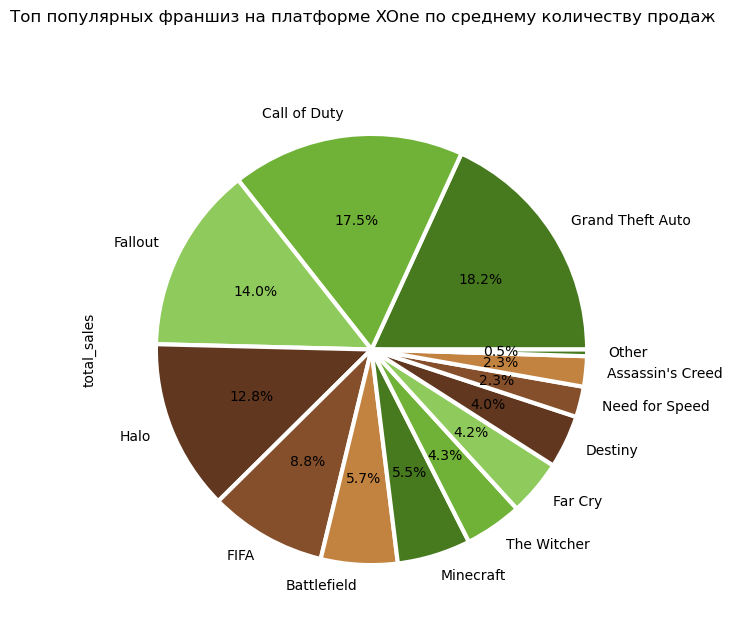

In [189]:
colors = ['#FFF1C9','#F7B7A3','#EA5F89','#9B3192',
          '#57167E','#2B0B3F']

minecraft_colors = ['#477A1E','#70B237','#8FCA5C','#61371F',
          '#854F2B','#C28340']

# create a pivot table for median total sales per franchise on Xbox One
(df_new
 .query('platform == "XOne"')
 .pivot_table(index='franchise', values='total_sales', aggfunc='median')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='pie',
       figsize=(7, 7),
       legend=False,
       title='Топ популярных франшиз на платформе XOne по среднему количеству продаж',
       subplots=True,
       autopct='%1.1f%%',
       wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
       colors=minecraft_colors)
);

**Conclusion:**  

1. The three main market leaders on Xbox One are **Call of Duty, GTA, and Fallout**. The first two coincide with PS4 leaders.  
2. Exclusives such as **Minecraft** represent only a small share of overall platform popularity.  

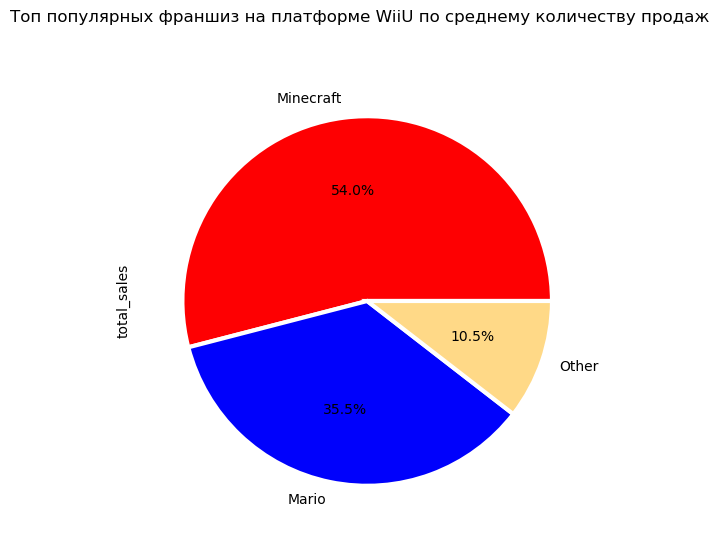

In [190]:
mario_colors = ['#FE0002','#0001FC','#FFD987','#6A0400']

# create a pivot table for median total sales per franchise on WiiU
(df_new
 .query('platform == "WiiU"')
 .pivot_table(index='franchise', values='total_sales', aggfunc='median')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='pie',
       figsize=(6, 6),
       legend=False,
       title='Топ популярных франшиз на платформе WiiU по среднему количеству продаж',
       subplots=True,
       autopct='%1.1f%%',
       wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
       colors=mario_colors)
);

**Conclusion:**  

1. Two clear market leaders on WiiU are **Mario** and **Minecraft**.  
2. A significant share of the platform’s popularity comes from exclusives, most notably **Mario**.  

#### Let’s examine how user and critic reviews affect sales within a single popular platform.  

In [191]:
# calculate correlation between reviews and sales on XOne
(df_new.query('platform == "XOne"').corr().loc[['total_sales'],['critic_score','user_score']])

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/2860522893.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_new.query('platform == "XOne"').corr().loc[['total_sales'],['critic_score','user_score']])


,critic_score,user_score
total_sales,0.428677,-0.070384


**Conclusion:**  

1. The correlation between **sales and critic scores** is **0.43** — noticeable but not strong enough to suggest a very tight dependency.  
2. The correlation between **sales and user scores** is much weaker at **0.07**. This suggests that players may still enjoy and buy less large-scale or niche games.  

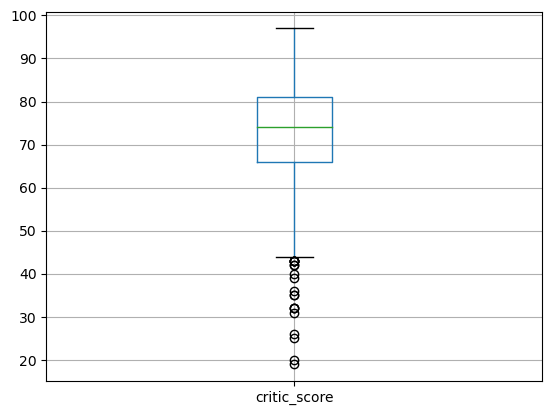

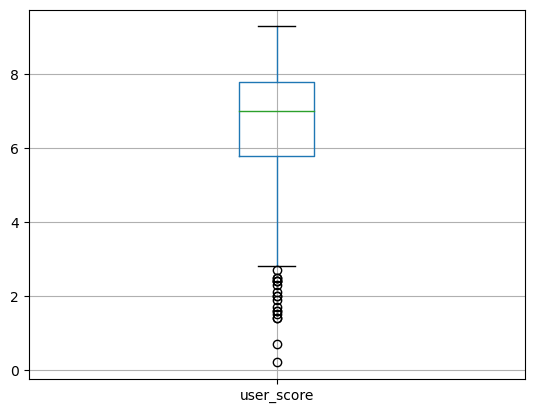

In [192]:
# examine the spread of critic and user scores
df_new.boxplot('critic_score');
plt.show()
df_new.boxplot('user_score');

**Conclusion:**  

1. There are many outliers at the lower bound in both critic and user scores.  
2. For critic scores, the median is more strongly pulled downward by such low values.  
3. Interestingly, for both critic and user scores, the interquartile range lies within 60%–80%.  

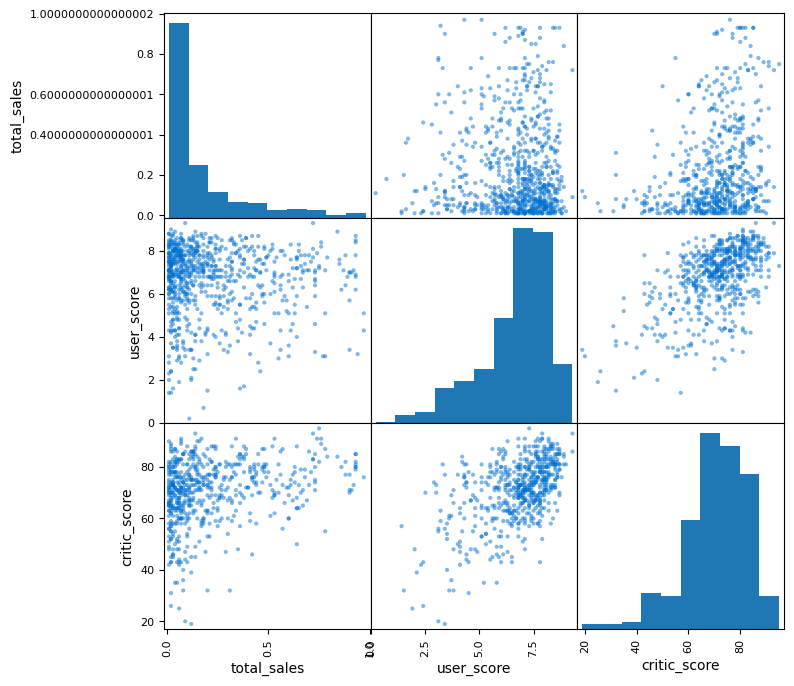

In [193]:
# build a scatter matrix for scores and sales below 1 million
data_for_matrix = df_new.loc[:, ['total_sales', 'user_score','critic_score']].query('total_sales < 1')
pd.plotting.scatter_matrix(data_for_matrix, figsize=(8, 8), color=['#0070D1']);

**Conclusion:**  

1. In the critic score vs. total sales quadrant, there is no strong direct correlation, but the empty spot in the bottom-right corner indicates that games with high sales rarely have low critic scores.  
2. In the user score vs. total sales quadrant, again no strong correlation is visible, but the empty spot in the bottom-right suggests that popular games rarely have poor user ratings. However, user ratings are more scattered overall.  
3. Critic and user scores show stronger correlation with each other. The cluster in the top-right suggests that high critic scores often coincide with high user ratings.  

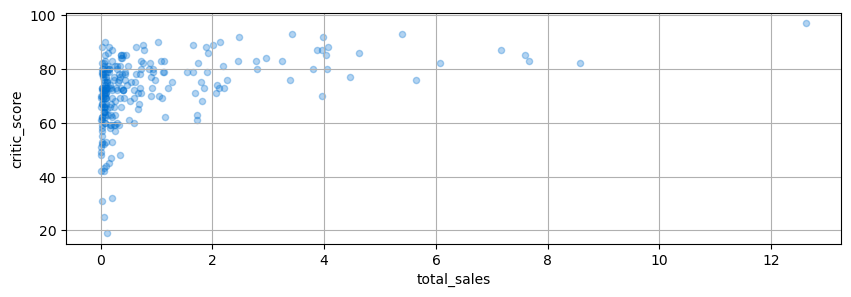

In [194]:
# build a scatter plot for total sales vs. critic scores on PS4
(df_new.query('platform == "PS4"')
    .plot(y='critic_score', x='total_sales',grid=True,
          figsize=(10, 3),kind='scatter',alpha=0.3, color=['#0070D1'])
);

**Conclusion:**  

1. Since sales values are highly dispersed along the upper boundary, many rating values appear on the left.  
2. The lowest ratings correlate with sales in the lower-left corner.  
3. In the sales range up to 500k copies, the majority of ratings fall between 60–80, though higher ratings also occur.  
4. For games with sales above 1 million, ratings rarely drop below 60 and are mostly above 80.  
5. Some correlation is observed: the higher the critic scores, the higher the sales volume.  

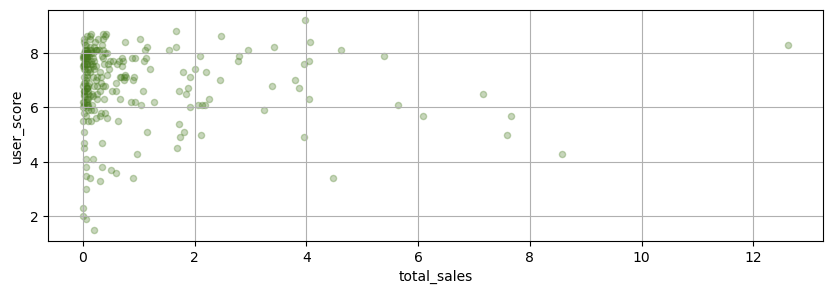

In [195]:
# build a scatter plot for total sales vs. user scores
(df_new.query('platform == "PS4"')
    .plot(y='user_score', x='total_sales',grid=True, figsize=(10, 3)
          ,kind='scatter',alpha=0.3, color = '#477A1E')
);

**Conclusion:**  

1. User ratings are less consistent compared to critic ratings.  
2. Sales do not strongly correlate with user ratings, and there is no clear negative correlation either.  

#### Compare findings with game sales on other platforms.

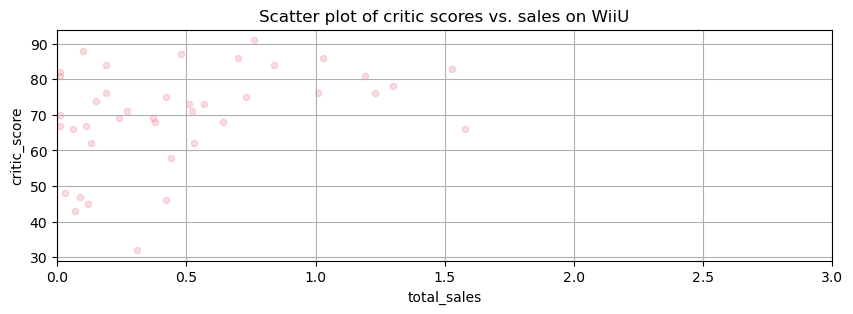

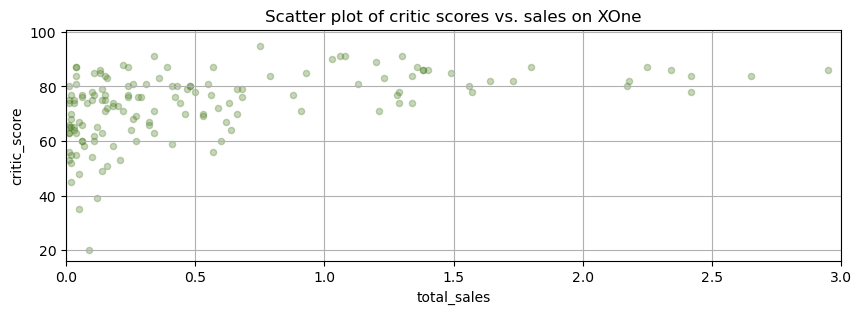

In [196]:
(df_new.query('platform == "WiiU"')
    .plot(y='critic_score', x='total_sales', grid=True,
          figsize=(10, 3), kind='scatter', alpha=0.3, xlim=(0,3),
          color=['#ef8b97'], title='Scatter plot of critic scores vs. sales on WiiU')
);
plt.show()

(df_new.query('platform == "XOne"')
    .plot(y='critic_score', x='total_sales', grid=True,
          figsize=(10, 3), kind='scatter', alpha=0.3, xlim=(0,3),
          color=['#477A1E'], title='Scatter plot of critic scores vs. sales on XOne')
);

**Conclusion:**

1. Critic scores on other platforms show similar distributions, with XOne and PS4 being nearly identical.  

#### Overall distribution of games by genre. What can be said about the most profitable genres? Are there genres with high and low sales?

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/2659625881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['genre_group'] = (


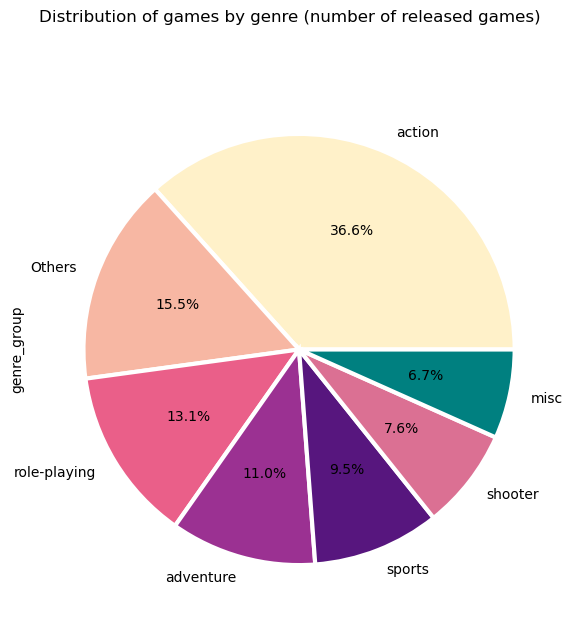

In [197]:
colors = ['#FFF1C9','#F7B7A3','#EA5F89','#9B3192',
          '#57167E','palevioletred','teal']

# collect the top-6 genres by the number of released games
big_genre_stat = df_new['genre'].value_counts().sort_values(ascending=False).head(6)

# add a grouping column for genres (rare genres go into "Others")
df_new['genre_group'] = (
    df_new['genre']
    .where(df_new['genre'].isin(big_genre_stat.index), 'Others')
)

# summary table for the chart
(df_new['genre_group']
.value_counts()
#.pivot_table(index='genre',values='name',aggfunc='count')
.sort_values(ascending=False)
.plot(kind='pie',figsize=(7,7), legend=False, 
      title='Distribution of games by genre (number of released games)', subplots=True, autopct='%1.1f%%', 
      wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, colors=colors)
);
plt.show()

**Conclusion:**  

1. The largest number of games are released in the action genre — 24%, misc — 12.2%, sports — 11.8%  
2. The fewest games are released in the puzzle, strategy, platform, and fighting genres — less than 4%  

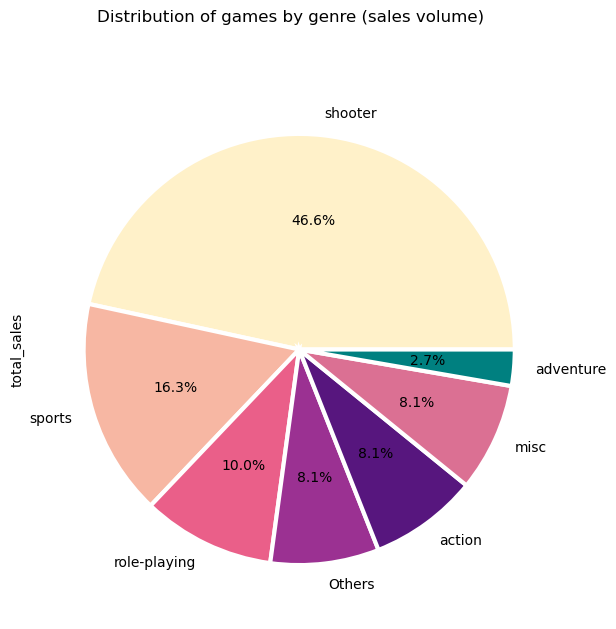

In [198]:
#summary table for the chart
(df_new
.groupby('genre_group')['total_sales'].median()
#.pivot_table(index='genre',values='total_sales',aggfunc='sum')
#.sort_values(by='total_sales',ascending=False)
.sort_values(ascending=False)
.plot(kind='pie',figsize=(7,7), legend=False, 
      title='Distribution of games by genre (sales volume)', subplots=True, autopct='%1.1f%%', 
      wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, colors=colors)
);

In the preprocessing section, we divided the dataset into 4 equal parts based on total global sales.
Now we will look at which genres dominate in the category of games with high and low sales.

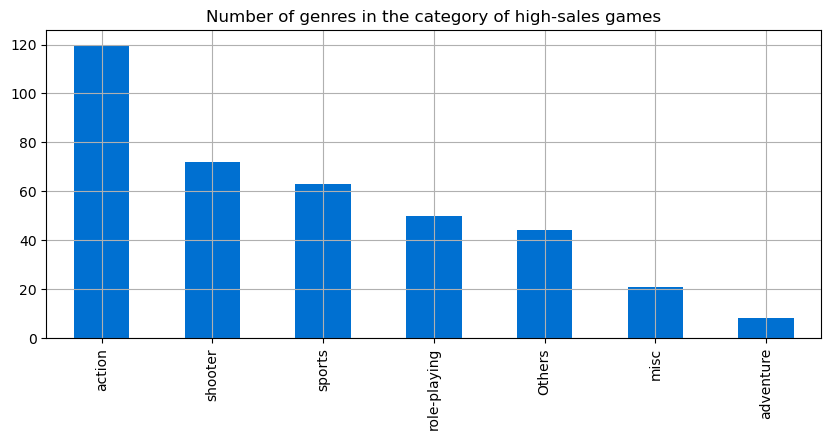

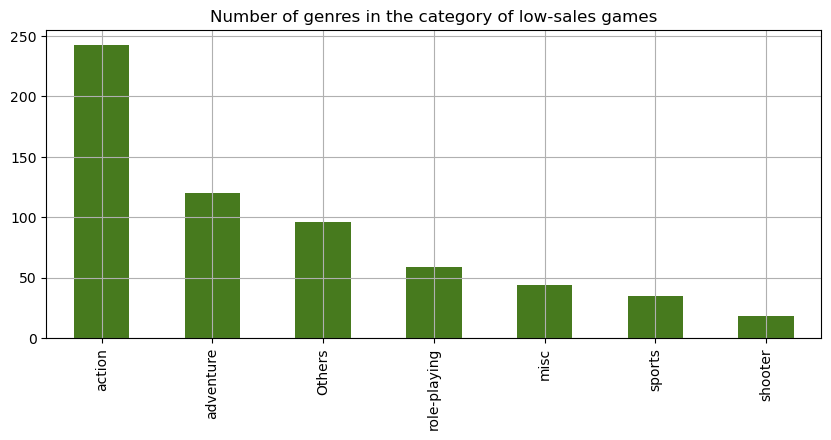

In [199]:
# bar chart of genres in the category of high-sales games
(df_new
.query('sales_category == "high"')['genre_group']
.value_counts()
.plot(kind='bar', figsize=(10,4), legend=False, 
      title='Number of genres in the category of high-sales games', color=['#0070D1'], grid=True)
)
plt.show();

# bar chart of genres in the category of low-sales games
(df_new
.query('sales_category == "low"')['genre_group']
.value_counts()
.plot(kind='bar', figsize=(10,4), legend=False, 
      title='Number of genres in the category of low-sales games', color=['#477A1E'], grid=True)
);

**Conclusion:**  

1. These charts are based on aggregated groups to average the number of games.  
2. In the high-sales category, most games are in the action genre. However, the same genre also ranks first in the low-sales category. Comparing this with the earlier charts, it can be explained by the fact that action games overall make up about 20% of all releases. Thus, the genre includes both very popular and less successful titles.  
3. The sports genre appears half as often as action, but shows much higher sales.  
4. The shooter genre ranks second among the most common games in the high-sales category. This is also visible in the pie charts.  
5. In the low-sales category, adventure ranks second. These games rarely appear in the high-sales category, which indicates not the number of releases but their generally low average profitability.  
6. Interestingly, with relatively small release volumes, shooter and sports games achieve high sales, while adventure games, despite larger volumes of releases, are among the lowest by median sales. The success of a genre should therefore be evaluated by median sales values.  

#### Section Summary:  
1. The highest number of released games occurred in 2008 and 2009.  
2. Over a span of 10 years, platforms lose momentum in the number of releases.  
3. PS4 and XOne are experiencing sales growth. By 2023, they are likely to be replaced by the next generation of platforms.  
4. Correlation between sales and critic reviews is 0.43 — noticeable but not very strong.  
5. Correlation between sales and user reviews is much weaker — 0.07.  
6. Shooters dominate most of the global top-10 sales.  
7. Exclusive titles often contribute a significant share of sales to a platform.  
8. Overall game distribution: action — 36%, RPG — 13%, adventure — 11%.  
   Genres with the smallest share (under 4%): puzzle, strategy, platform, fighting.  
9. The sports genre produces three times fewer games than action but achieves higher sales.  
10. Adventure leads in the low-sales category.  
11. Total sales values vary widely. Successful and well-known franchises sell many times more, significantly skewing the mean. Most games have global sales below 1 million, while the top title (Mario) exceeds 35 million.  

### User Profile by Region

Define for each region (NA, EU, JP):  
- The most popular platforms (top 5). Describe the differences in sales shares.  
- The most popular genres (top 5). Explain the differences.  
- Does the ESRB rating affect sales in each region?  

#### Region NA (North America)

##### Popular Games

In [200]:
#create a table where the share of sales in the NA region is higher than in other regions  
#apply a filter for the "high" sales category to select the best-selling games
na_stat = (df_new
.query('na_sales_part > eu_sales_part \
       and na_sales_part > jp_sales_part \
       and na_sales_part > other_sales/total_sales \
       and sales_category == "high"'
      )
)

In [201]:
#look at the NA table, apply sorting by the games where the NA sales share is the highest
na_stat.sort_values(by='na_sales_part',ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
1615,Madden NFL 17,XOne,2016.0,sports,1.08,0.02,0.0,0.13,83.0,5.9,E,1.23,Other,high,0.878049,0.016260,0.0,2,sports
2114,Madden NFL 16,X360,2015.0,sports,0.85,0.02,0.0,0.10,NaN,5.1,E,0.97,Other,high,0.876289,0.020619,0.0,2,sports
829,Madden NFL 15,X360,2014.0,sports,1.77,0.06,0.0,0.22,NaN,5.5,E,2.05,Other,high,0.863415,0.029268,0.0,2,sports
641,Madden NFL 16,XOne,2015.0,sports,2.08,0.08,0.0,0.26,84.0,6.1,E,2.42,Other,high,0.859504,0.033058,0.0,2,sports
2183,NBA 2K16,X360,2015.0,sports,0.79,0.05,0.0,0.10,NaN,3.2,E,0.94,Other,high,0.840426,0.053191,0.0,2,sports
1183,Madden NFL 15,XOne,2014.0,sports,1.31,0.09,0.0,0.16,80.0,6.4,E,1.56,Other,high,0.839744,0.057692,0.0,2,sports
2024,NBA 2K17,XOne,2016.0,sports,0.86,0.06,0.0,0.11,90.0,6.2,E,1.03,Other,high,0.834951,0.058252,0.0,2,sports
680,NBA 2K16,XOne,2015.0,sports,1.95,0.15,0.0,0.24,86.0,6.2,E10+,2.34,Other,high,0.833333,0.064103,0.0,<NA>,sports
1130,NBA 2K15,X360,2014.0,sports,1.35,0.11,0.0,0.17,NaN,3.0,E,1.63,Other,high,0.828221,0.067485,0.0,2,sports
4495,MLB 14: The Show,PS3,2014.0,sports,0.35,0.00,0.0,0.08,81.0,6.8,E,0.43,Other,high,0.813953,0.000000,0.0,2,sports


**Conclusion:**

1. The table above shows the games with the highest share of total sales in North America.  
2. The most characteristic games for North America are American football — logically — and basketball.  
3. American users prefer the sports genre.  
4. The share of these games exceeds 90%, meaning they are characteristic only for this region.  

In [202]:
# look at the NA table, sorting by games with the highest absolute sales values
na_stat.sort_values(by='total_sales',ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
31,Call of Duty: Black Ops 3,PS4,2015.0,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63,Call of Duty,high,0.412167,0.400547,0.024607,<NA>,shooter
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68,Pokemon,high,0.372432,0.298801,0.265411,<NA>,role-playing
96,Super Smash Bros. for Wii U and 3DS,3DS,2014.0,fighting,3.27,1.37,2.43,0.48,NaN,NaN,unknown,7.55,Other,high,0.433113,0.181457,0.321854,<NA>,Others
99,Call of Duty: Black Ops 3,XOne,2015.0,shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.39,Call of Duty,high,0.621110,0.285521,0.001353,<NA>,shooter
108,Pokemon Sun/Moon,3DS,2016.0,role-playing,2.98,1.45,2.26,0.45,NaN,NaN,unknown,7.14,Pokemon,high,0.417367,0.203081,0.316527,<NA>,role-playing


**Conclusion:**  

1. The table above shows games with the largest share of total sales in North America, sorted by the top-selling games.  
2. We can see the huge popularity of Call of Duty, Pokémon, and Mario.  
3. The share of these games in the region is about 80%. If something leads in North America, it usually does so with a big gap from other regions.  

##### Popular Platforms

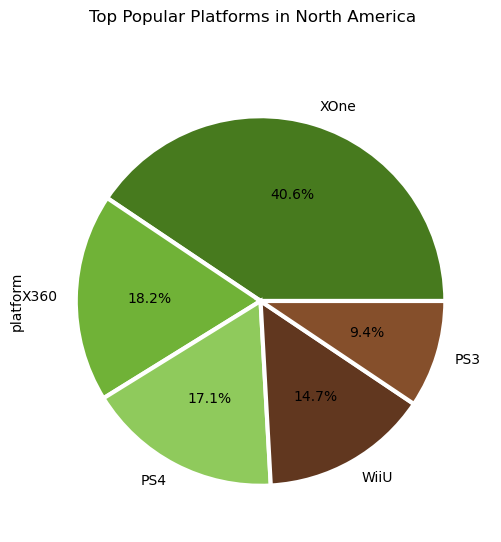

In [203]:
(na_stat['platform'].value_counts().head()
.plot(kind='pie', figsize=(6, 6), legend=False,
      title='Top Popular Platforms in North America', subplots=True, 
      wedgeprops={'linewidth': 3, 'edgecolor': 'white'}, colors=minecraft_colors, autopct='%1.1f%%')
);

**Conclusion:**

1. Three market leaders are visible: XOne, PS4, X360, and WiiU. Their shares in the region are fairly comparable in size (except for XOne).  
2. It is clear that X360 has already been replaced by XOne.  

##### Popular Genres

In [204]:
# look at genre groups in North America
(na_stat
.pivot_table(index='genre_group',values='na_sales',aggfunc=['median','sum','count']).head()
#.sort_values(by='median',ascending=False).head(5)
)

,median,sum,count
,na_sales,na_sales,na_sales
genre_group,,,
Others,0.660,16.01,14
action,0.410,31.34,53
adventure,0.390,0.78,2
misc,0.365,6.88,14
role-playing,0.430,19.63,25


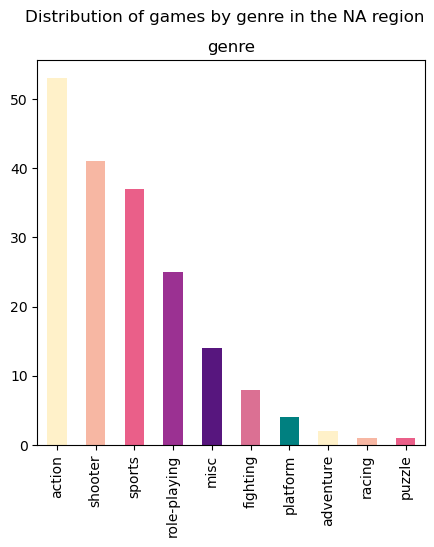

In [205]:
(na_stat['genre'].value_counts()
.plot(kind='bar', figsize=(5,5), legend=False,  
      title='Distribution of games by genre in the NA region', subplots=True, color=colors)
);

**Conclusion:**  

1. It is clear that in terms of the number of released games, *action* still leads, just like worldwide.  
2. However, we previously found that in this region only two genres from this chart show the highest popularity — *sports* and *misc*.  

##### Regional Conclusion:

1. In North America, three platforms are popular: Xbox, PlayStation, and Wii.  
2. A typical user in the region prefers games related to physical activities — mainly sports simulations.  
3. Shooters or classic story-driven RPGs are not among the top popular games. Likely, the console is often used as an additional group activity rather than for single-player campaigns.  
4. There is no strong inclination toward story-based games. Multiplayer/team games are more favored.  
5. Mario is top :)  

#### Region EU (Europe)

##### Popular Games

In [206]:
#create a table where the share of sales in the EU region is higher than in other regions  
#apply a filter by the "high" sales category to select the best-selling games
eu_stat = (df_new
.query('eu_sales_part > na_sales_part \
       and eu_sales_part > jp_sales_part \
       and eu_sales_part > other_sales/total_sales \
       and sales_category == "high"'
      )
)

In [207]:
#view the EU table, sort by the games with the highest sales share in the EU
eu_stat.sort_values(by='eu_sales_part',ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
4214,Football Manager 2015,PC,2014.0,simulation,0.00,0.44,0.00,0.03,80.0,6.0,unknown,0.47,Other,high,0.000000,0.936170,0.000000,<NA>,Others
3123,Farming Simulator 17,PC,2016.0,simulation,0.03,0.58,0.00,0.04,64.0,8.0,E,0.65,Other,high,0.046154,0.892308,0.000000,2,Others
2717,Nintendo Presents: New Style Boutique 2 - Fash...,3DS,2015.0,misc,0.03,0.66,0.02,0.04,NaN,NaN,unknown,0.75,Other,high,0.040000,0.880000,0.026667,<NA>,misc
1677,Farming Simulator 2015,PC,2014.0,simulation,0.08,1.04,0.00,0.07,NaN,NaN,unknown,1.19,Other,high,0.067227,0.873950,0.000000,<NA>,Others
571,FIFA 17,XOne,2016.0,sports,0.43,2.05,0.00,0.17,84.0,5.5,E,2.65,FIFA,high,0.162264,0.773585,0.000000,2,sports


**Conclusion:**

1. The table above shows games with the largest share of total sales in the EU.  
2. It is clear that popular games in Europe account for about 35–40% of total sales.  
3. The top list includes two football or farming simulation games, two sports games, and one in the misc genre.  
4. It can be concluded that EU users particularly enjoy football and strategy games.  
5. The top-5 games mostly have ratings suitable for all ages.  

In [208]:
# look at the table for the EU, sort by games with the highest absolute sales
eu_stat.sort_values(by='total_sales',ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
42,Grand Theft Auto V,PS4,2014.0,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,Grand Theft Auto,high,0.313788,0.500000,0.030111,4,action
77,FIFA 16,PS4,2015.0,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,FIFA,high,0.130536,0.713287,0.006993,2,sports
87,Star Wars Battlefront (2015),PS4,2015.0,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98,Other,high,0.374687,0.437343,0.027569,<NA>,shooter
92,Call of Duty: Advanced Warfare,PS4,2014.0,shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66,Call of Duty,high,0.366841,0.454308,0.018277,4,shooter
94,FIFA 17,PS4,2016.0,sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60,FIFA,high,0.086842,0.756579,0.010526,2,sports


**Conclusion:**  

1. The table above shows the games with the highest share of total sales in the EU, sorted by the top-selling games.  
2. Three popular franchises stand out: GTA, Call of Duty, FIFA, and StarWars.  
3. The dominant genres are action/shooter/sports.  
4. In the EU, players prefer games with online multiplayer functionality (as evidenced by the popularity of franchises that include online modes).  
5. There is noticeable popularity of games with an M rating, which is arguably understated, since it’s difficult to imagine games more violent than GTA or Gears of War. Compared to NA, EU users appear older and are more likely to play games with high age ratings.  

##### Popular Platforms

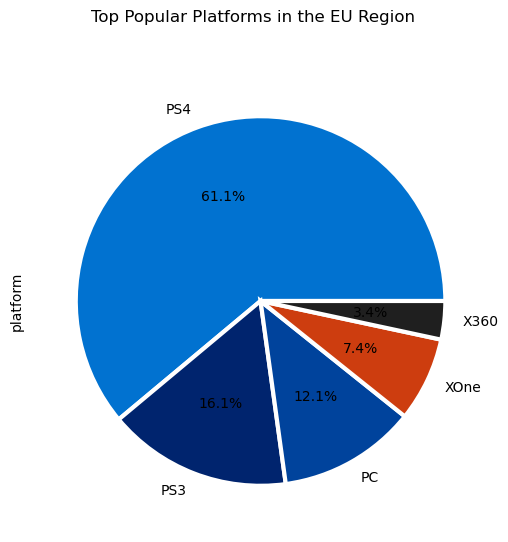

In [209]:
(eu_stat['platform'].value_counts().head()
.plot(kind='pie', figsize=(6, 6), legend=False,
      title='Top Popular Platforms in the EU Region', subplots=True, 
      wedgeprops={'linewidth': 3, 'edgecolor': 'white'}, colors=ps_colors, autopct='%1.1f%%')
);

**Conclusion:**  

1. A clear leader is visible — PS.  
2. The shares of the other platforms are comparable in size.  

##### Popular Genres

In [210]:
# look at genre groups in EU
(eu_stat
.pivot_table(index='genre_group',values='na_sales_part',aggfunc=['median','sum','count']).head()
#.sort_values(by='median',ascending=False).head(5)
)

,median,sum,count
,na_sales_part,na_sales_part,na_sales_part
genre_group,,,
Others,0.307413,6.906592,26
action,0.341063,17.787474,54
adventure,0.316702,1.928809,6
misc,0.385199,1.594720,5
role-playing,0.352859,4.399616,13


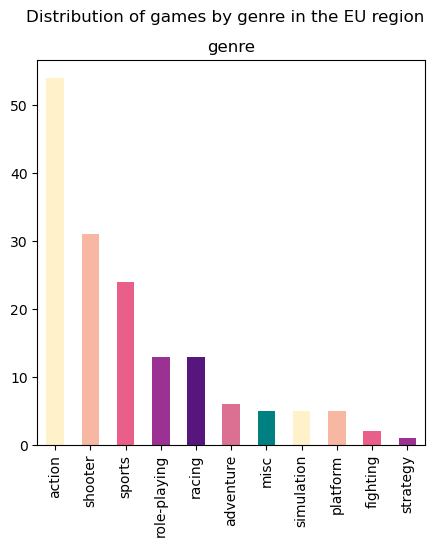

In [211]:
(eu_stat['genre'].value_counts()
.plot(kind='bar', figsize=(5,5), legend=False,  
      title='Distribution of games by genre in the EU region', subplots=True, color=colors)
);

**Conclusion:**  

1. It is clear that in terms of the number of released games, action still dominates, as in the global market. However, the tables above show that in the EU region this genre is genuinely popular. Sports and shooter games are also highly represented.  
2. The chart is similar to that of the North American region. A notable difference is that RPG games are more popular in NA, while racing games are more popular in the EU.  

##### Conclusion for the region:

1. Distinctive features of EU players include a love for soccer games, life simulations, and shooters. The main genres are sports/shooter/action.  
2. EU players prefer games with multiplayer server options (as evidenced by the popularity of franchises with online modes).  
3. The most popular platform is PS4.  
4. Among major franchises, they prefer GTA/Call of Duty/FIFA.  

#### Region JP (Japan)

##### Popular Games

In [212]:
#create a table where the share of sales in the JP region is higher than in other regions
#apply a filter by sales category "high" to select the best-selling games
jp_stat = (df_new
.query('jp_sales_part > na_sales_part \
       and jp_sales_part > eu_sales_part \
       and jp_sales_part > other_sales/total_sales \
       and sales_category == "high"'
      )
)

In [213]:
#look at the JP table, sort by the games where the sales share in JP is the highest
jp_stat.sort_values(by='jp_sales_part',ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
3177,Dragon Quest Monsters Joker 3,3DS,2016.0,role-playing,0.0,0.0,0.63,0.0,NaN,NaN,unknown,0.63,Other,high,0.0,0.0,1.0,<NA>,role-playing
563,Yokai Watch 2 Shinuchi,3DS,2014.0,role-playing,0.0,0.0,2.68,0.0,NaN,NaN,unknown,2.68,Other,high,0.0,0.0,1.0,<NA>,role-playing
694,Yokai Watch Busters,3DS,2015.0,action,0.0,0.0,2.29,0.0,NaN,NaN,unknown,2.29,Other,high,0.0,0.0,1.0,<NA>,action
4016,Dragon Quest Heroes: The World's Tree Woe and ...,PS3,2015.0,action,0.0,0.0,0.49,0.0,NaN,NaN,unknown,0.49,Other,high,0.0,0.0,1.0,<NA>,action
3593,Yokai Sangokushi,3DS,2016.0,action,0.0,0.0,0.56,0.0,NaN,NaN,unknown,0.56,Other,high,0.0,0.0,1.0,<NA>,action


**Conclusion:**  

1. The table above shows the games where Japan has the largest share of total sales.  
2. The RPG/Action genre stands out.  
3. Many games do not have a rating, possibly because not all games are assigned one.  
4. There is a strong response to local/domestic games.  

In [214]:
# look at the table for JP, sort by the games with the highest absolute sales
jp_stat.sort_values(by='total_sales',ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,franchise,sales_category,na_sales_part,eu_sales_part,jp_sales_part,rating_range,genre_group
312,Monster Hunter 4 Ultimate,3DS,2014.0,role-playing,0.68,0.48,2.62,0.11,86.0,8.7,T,3.89,Other,high,0.174807,0.123393,0.673522,3,role-playing
406,Monster Hunter X,3DS,2015.0,action,0.27,0.21,2.79,0.05,NaN,NaN,unknown,3.32,Other,high,0.081325,0.063253,0.840361,<NA>,action
412,Yokai Watch 2 Ganso/Honke,3DS,2014.0,role-playing,0.09,0.00,3.18,0.01,NaN,NaN,unknown,3.28,Other,high,0.027439,0.000000,0.969512,<NA>,role-playing
457,Animal Crossing: Happy Home Designer,3DS,2015.0,simulation,0.51,1.02,1.40,0.12,66.0,6.9,E,3.05,Other,high,0.167213,0.334426,0.459016,2,Others
563,Yokai Watch 2 Shinuchi,3DS,2014.0,role-playing,0.00,0.00,2.68,0.00,NaN,NaN,unknown,2.68,Other,high,0.000000,0.000000,1.000000,<NA>,role-playing


**Conclusion:**  

1. The table above shows the games where Japan has the largest share of total sales, sorted by the top-selling games.  
2. Nintendo DS is highly popular.  
3. The popularity of RPG games indicates that players prefer single-player experiences.  
4. The sales share of these games in the region does not exceed 40%.  
5. Among major franchises, Pokémon is the preferred choice.  

##### Popular Platforms

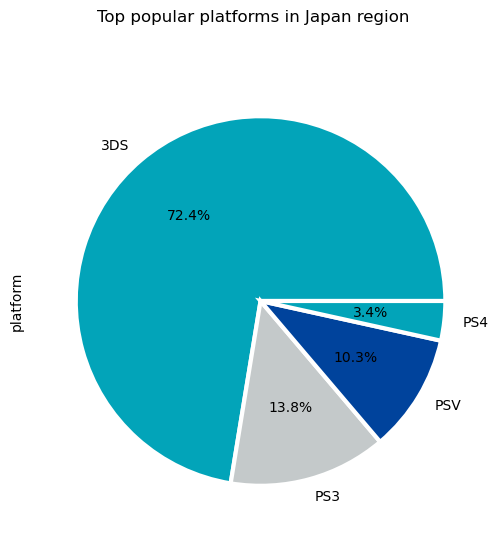

In [215]:
three_ds_colors = ['#02a4b9','#c4c9ca','#00439C','#02a4b9','#bc181a']

(jp_stat['platform'].value_counts().head()
.plot(kind='pie',figsize=(6, 6), legend=False,
      title='Top popular platforms in Japan region', subplots=True, 
      wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, colors=three_ds_colors, autopct='%1.1f%%')
);

**Conclusion:**  

1. Three market leaders are visible: 3DS, PS3, PSV. Their shares in the region are quite comparable in size.  
2. New platforms like XOne/PS4 are clearly slow to enter the market.  
3. PSP and 3DS are popular, indicating a strong preference for portable gaming platforms.  

##### Popular Genres

In [216]:
# look at genre groups in JP
(jp_stat
.pivot_table(index='genre_group',values='jp_sales',aggfunc=['median','sum','count'])
#.sort_values(by='median',ascending=False).head(5)
)

,median,sum,count
,jp_sales,jp_sales,jp_sales
genre_group,,,
Others,0.565,2.80,4
action,0.525,9.69,10
misc,0.810,1.62,2
role-playing,0.630,12.33,11
sports,0.195,0.39,2


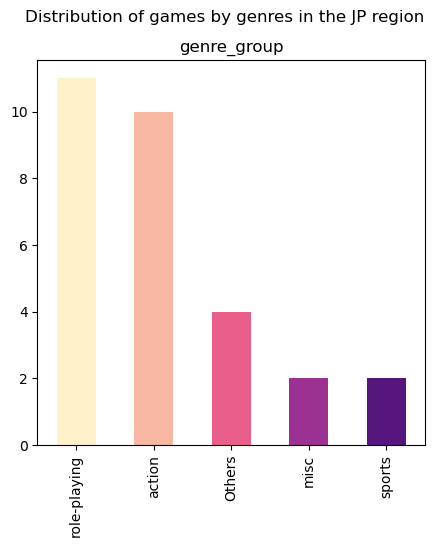

In [217]:
(jp_stat['genre_group'].value_counts()
.plot(kind='bar', figsize=(5,5), legend=False,  
      title='Distribution of games by genres in the JP region', subplots=True, color=colors)
);

**Conclusion:**  

1. It is clear that the RPG genre strongly dominates (and only in this region). Action is in second place.  

##### Regional Summary:

1. Games preferred by Japanese players are mostly developed in Japan.  
2. There is no clear attachment to old or new games.  
3. Players prefer single-player games.  
4. RPG/Action genres stand out in preferences.  
5. Among major franchises, they prefer Monster Hunter.  
6. They often play games with low age ratings. Likely, children play more often overall.  
7. The region differs from others both in genre preferences and in unique choices.  

#### ESRB Rating

In [218]:
# earlier we added a column with numeric grading for ratings
# let's check the correlation between age rating and sales share in the NA region
(df_new.corr().loc['rating_range':,['na_sales_part']])

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/1117519642.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_new.corr().loc['rating_range':,['na_sales_part']])


,na_sales_part
rating_range,0.111823


In [219]:
#let's check the correlation between age rating and sales share in the EU region
(df_new.corr().loc['rating_range':,['eu_sales_part']])

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/4094541079.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_new.corr().loc['rating_range':,['eu_sales_part']])


,eu_sales_part
rating_range,-0.119376


In [220]:
# let's check the correlation between age rating and sales share in the Japan region
(df_new.corr().loc['rating_range':,['jp_sales_part']])

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/1212739327.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_new.corr().loc['rating_range':,['jp_sales_part']])


,jp_sales_part
rating_range,-0.003596


In [221]:
(df_new.corr().loc['rating_range':,['total_sales']])

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_43949/2726174462.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_new.corr().loc['rating_range':,['total_sales']])


,total_sales
rating_range,0.092317


**Conclusion:**  

1. The rating has the least impact on sales in the NA region. As seen earlier, players prefer age-restricted games, so ratings hardly affect sales.  
2. The strongest negative correlation between rating and sales is observed in the EU.  
3. In Japan, there is also a slight negative correlation.  
4. Overall, the rating has only a weak effect on sales, and the correlation is more direct than inverse.  

### Statistical Data Analysis

Test the hypotheses:  
- The mean user ratings for Xbox One and PC platforms are equal;  
- The mean user ratings for Action and Sports genres are different.  

Set the alpha threshold yourself.

Explain:  
- How you formulated the null and alternative hypotheses;  
- Which test you used to check the hypotheses and why.

#### The mean user ratings for Xbox One and PC are equal

**Null Hypothesis (H0):** The mean user ratings for Xbox One and PC are equal.  

**Alternative Hypothesis (H1):** The mean user ratings for Xbox One are greater than those for PC.  

**Alternative Hypothesis (H2):** The mean user ratings for Xbox One are lower than those for PC.  

In [222]:
# select two columns with data for PC and Xbox
pc_stat = (df_new
                .query('platform == "PC" and user_score >= 0')['user_score']
          )
xbox_stat = (df_new
                .query('platform == "XOne" and user_score >= 0')['user_score']
            )

In [223]:
alpha = 0.05

results = st.ttest_ind(pc_stat, xbox_stat, alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.9477474604032579
Failed to reject the null hypothesis


In [224]:
alpha = 0.05

results = st.ttest_ind(pс_stat, xbox_stat, alternative='less')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.05225253959674207
Failed to reject the null hypothesis


#### The average user ratings of Action and Sports genres are different

**Null hypothesis (H₀):** The average user ratings of Action and Sports genres are equal  

**Alternative hypothesis (H₁):** The average user ratings of Action > Sports  

**Alternative hypothesis (H₂):** The average user ratings of Action < Sports

In [225]:
sport_stat = df_new.query('genre == "action" and user_score >= 0')['user_score']
action_stat = df_new.query('genre == "sports" and user_score >= 0')['user_score']

In [226]:
alpha = 0.05

results = st.ttest_ind(action_stat, sport_stat, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-значение: 1.0
Failed to reject the null hypothesis


In [227]:
alpha = 0.05

results = st.ttest_ind(action_stat, sport_stat, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-значение: 1.4355573992552932e-19
Reject the null hypothesis


#### Conclusion:
1. The hypothesis "The average user ratings of Xbox One and PC platforms are equal" is not rejected.  
This means that user ratings do not depend on the gaming platform and are the same for both video game consoles and PC games. Although PC is not the most popular platform, users still enjoy games on it just as much as on the popular Xbox.  

2. The hypothesis "The average user ratings of Action and Sports genres are equal" is not rejected.  
This means that Action games have, on average, the same ratings as Sports games.  

### General Conclusion

1. Campaign strategies should be divided by regions, as markets have their own regional differences.  

2. **North America (NA):**  
   - Focus on team sports games.  
   - Priority for Xbox One releases, including exclusives.  
   - Consider sequels of well-known games and franchises.  

3. **Europe (EU):**  
   - Invest in major franchises like GTA, COD, FIFA.  
   - New action/shooter games are also promising.  
   - Sports and sports simulation games (continuations of popular franchises like FIFA) remain strong regardless of rating.  
   - Games must support online multiplayer.  
   - Platform of choice: PS4.  
   - Niche strategies can also be considered.  

4. **Japan (JP):**  
   - Focus on RPGs and portable platforms (3DS/DS).  
   - Avoid PS4 releases, especially exclusives.  
   - Consider children’s or heavily animated games from local developers.  
   - Games with farming/collecting mechanics and colorful graphics are suitable.  

5. User ratings do not strongly correlate with sales; critic ratings show a slightly higher correlation and should be prioritized.  

6. Sequels of major franchises are expected to remain popular in the coming years.  

7. Despite consoles being the most popular platforms, user ratings of console games (e.g., Xbox One) are higher than those of PC games.  

8. Sports games deserve special attention, as they are among the top leaders in both sales volume and user ratings (even compared to the popular Action genre).  